In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import optax
import corner
import matplotlib.pyplot as plt

from functools import partial
import jimgw

import distrax
import haiku as hk     #
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple   #

from vi_routines import make_flow_model

Array = jnp.ndarray
PRNGKey = Array
OptState = Any

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


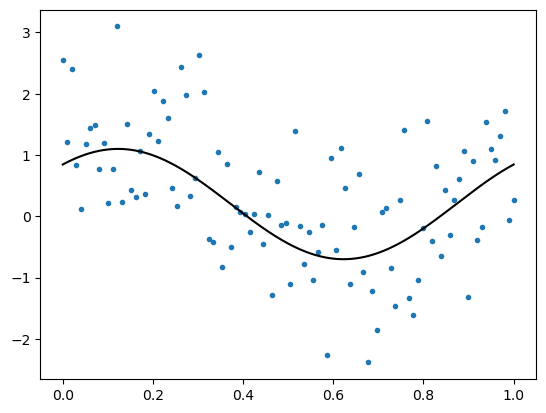

Array(-39.43828, dtype=float32)

In [2]:
def model_sine(x, a, b, c):        #data model with parameters theta=(a,b,c)
    return a*jnp.sin(2*np.pi*x+b)+c           #sine with frequency 1

def simulate_data(model, theta, sigma_noise, n_data_points):
    x_vec = jnp.linspace(0, 1, n_data_points)
    return model(x_vec, *theta) + np.random.normal(0, sigma_noise, n_data_points)

theta = [0.9, 0.8, 0.2]

def log_L(theta, data, sigma_noise, n_data_points):
    x_vec = np.linspace(0, 1, n_data_points)
    model=model_sine(x_vec, *theta)
    return -1/(2*sigma_noise**2) * np.sum((data-model)**2)

x_vec = np.linspace(0, 1, 100)
x_vec_2 = np.linspace(0, 1, 1000)
data = simulate_data(model_sine, theta, 1, 100)
theory = model_sine(x_vec_2, *theta) 
plt.plot(x_vec, data, '.')  
plt.plot(x_vec_2, theory, '-k')    
plt.show()

log_L(theta, data, 1, 100)

In [12]:
model_sine(jnp.atleast_2d(x_vec), jnp.atleast_2d(np.array([2,1])).T, jnp.atleast_2d(np.array([0,0])).T, jnp.atleast_2d(np.array([0,0])).T).shape

(2, 100)

In [3]:
log_L([0.9,0.8,0.2], data, 1., 100)

Array(-58.9116, dtype=float32)

In [38]:
#@jax.jit

# likelihood function
class LogL(object):
    
    def __init__(self, true_gw_params = dict(A=0.9,B=0.8,C=0.2), sigma_noise = 1., n_data_points=100):
        
        self.true_gw_params = true_gw_params
        self.sigma_noise = sigma_noise
        self.x_vec = np.linspace(0, 1, n_data_points)
        self.data = simulate_data(model_sine, [true_gw_params['A'],true_gw_params['B'], true_gw_params['C']], sigma_noise, n_data_points)

        self.bounds = dict(          #not used anywhere 
            A = [0.,2.],
            B = [-jnp.pi, jnp.pi],
            C = [-1., 1.],
        )
    
    def __call__(self, gw_params):
        model_signal = model_sine(jnp.atleast_2d(self.x_vec), jnp.atleast_2d(gw_params['A']).T, jnp.atleast_2d(gw_params['B']).T, jnp.atleast_2d(gw_params['C']).T)
        residuals = jnp.array(self.data-model_signal)
        return -1/(2*self.sigma_noise**2) * jnp.sum(residuals**2, axis=(1))
    
    @property
    def gw_params(self):
        gw_params = ['A','B','C']
        return gw_params

    def array_to_phys(self, x: Array) -> dict:           #transformation from the domain of the flow to 
        p = dict()
        p['A']=x[:,0]+1  #0 to 2                       
        p['B']=x[:,1]*jnp.pi   #-pi to pi
        p['C']=x[:,2]      #-1 to 1

        return p

In [39]:
#Neural network setup

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )
    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p)

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)    
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


In [40]:
log_l = LogL()  

In [41]:
test_params = dict(
        A = jnp.array([0.5,2.]),
        B=jnp.array([0.5,1.]),
        C=jnp.array([0.5,0.8]))

In [42]:
log_l(test_params)

Array([-52.910355, -97.41497 ], dtype=float32)

log likelihood of true params = [-47.130424]


  0%|          | 0/1000 [00:00<?, ?it/s, loss=123.38, T=1]

Epoch 0, loss 123.38365173339844


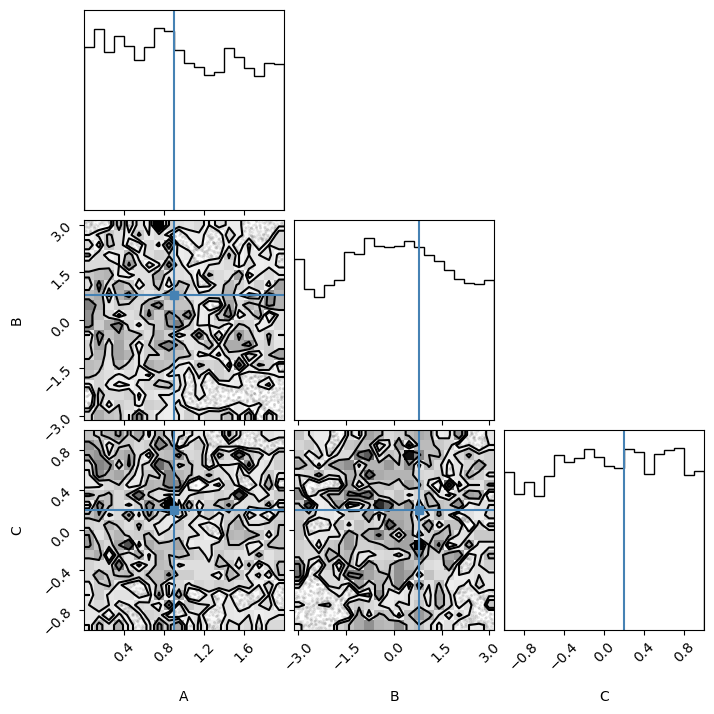

  5%|▌         | 50/1000 [00:37<07:57,  1.99it/s, loss=51.58, T=1]  

Epoch 50, loss 51.58219528198242


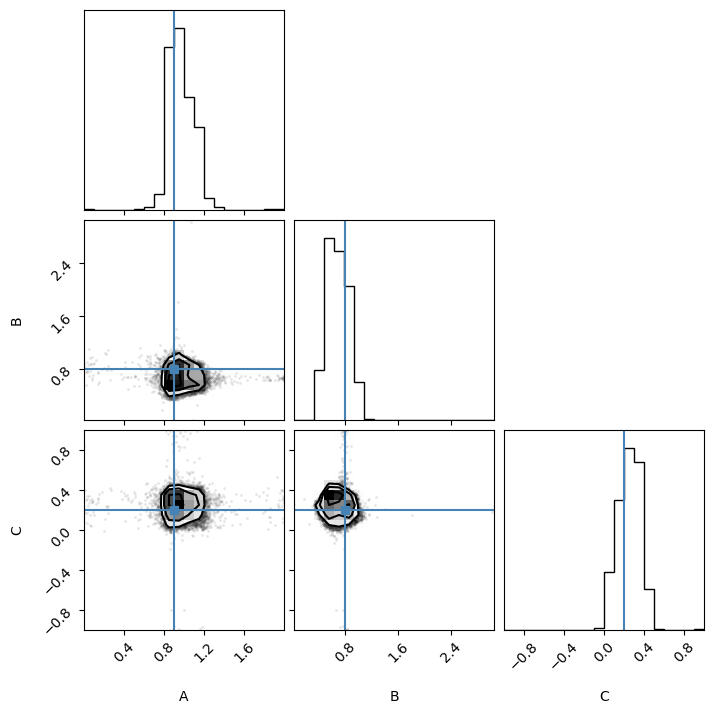

 10%|█         | 100/1000 [01:00<06:14,  2.40it/s, loss=51.25, T=1]

Epoch 100, loss 51.248905181884766


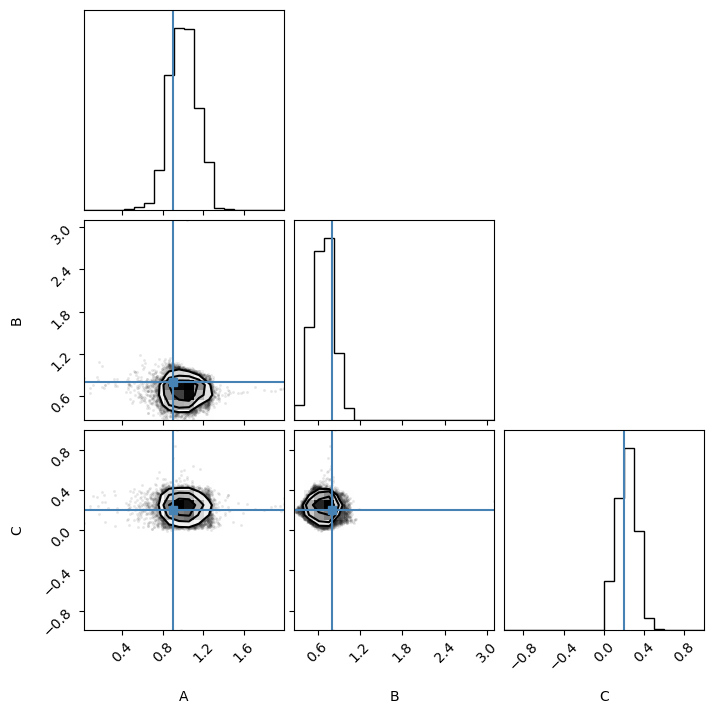

 15%|█▌        | 150/1000 [01:25<06:43,  2.11it/s, loss=51.13, T=1]

Epoch 150, loss 51.13156509399414


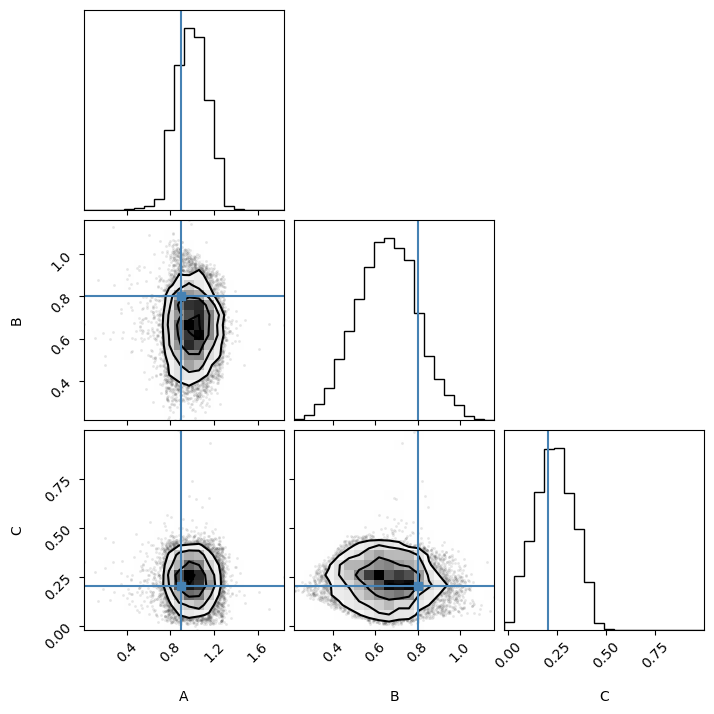

 20%|██        | 200/1000 [01:49<06:54,  1.93it/s, loss=51.05, T=1]

Epoch 200, loss 51.0505256652832


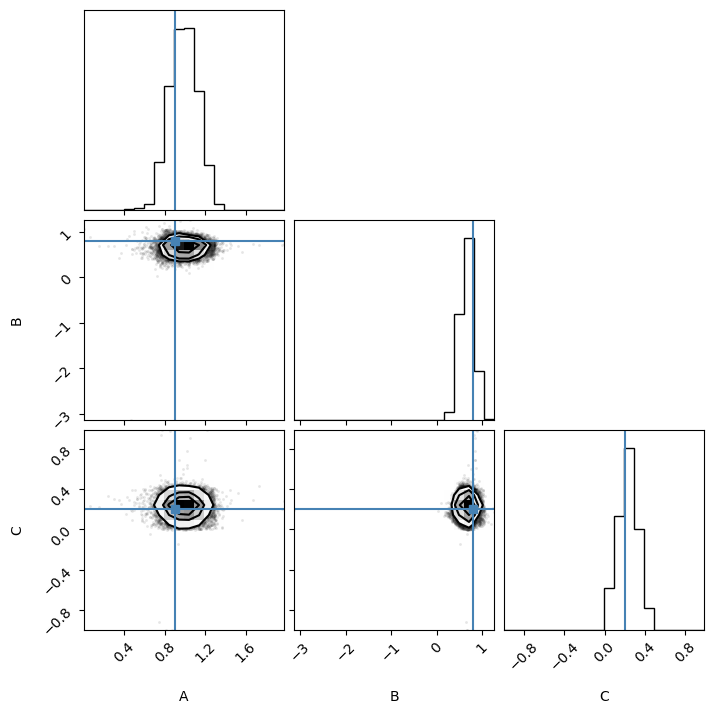

 25%|██▌       | 250/1000 [02:15<05:51,  2.13it/s, loss=51.07, T=1]

Epoch 250, loss 51.074501037597656


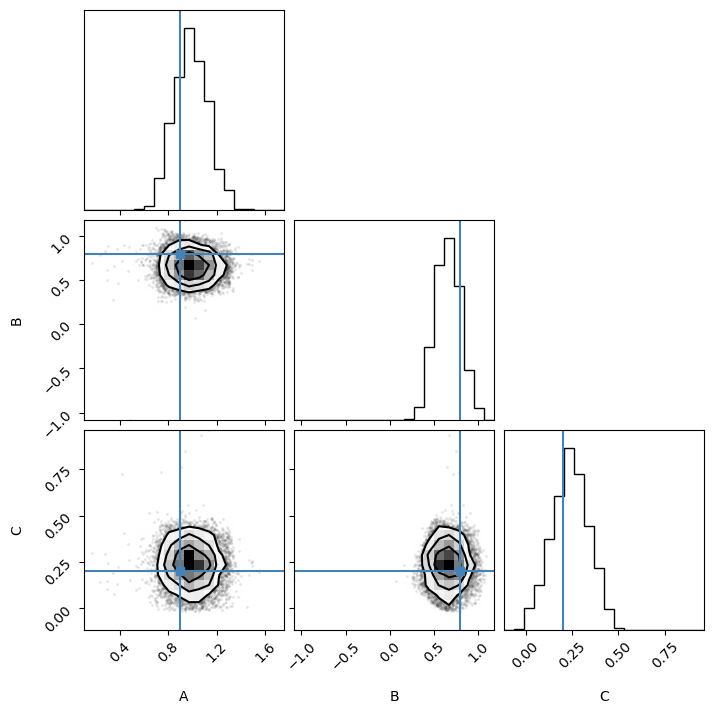

 30%|███       | 300/1000 [02:40<05:57,  1.96it/s, loss=51.06, T=1]

Epoch 300, loss 51.056209564208984


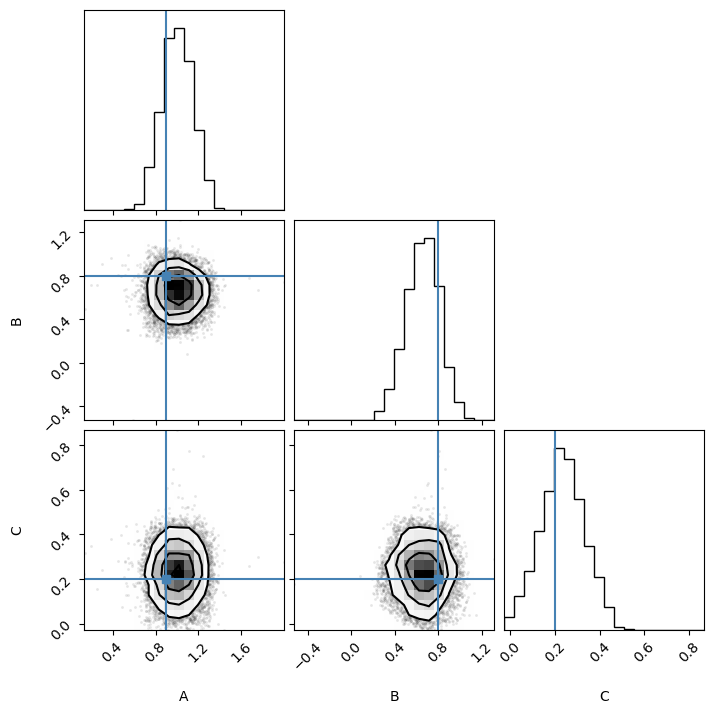

 35%|███▌      | 350/1000 [03:03<04:27,  2.43it/s, loss=51.02, T=1]

Epoch 350, loss 51.021385192871094


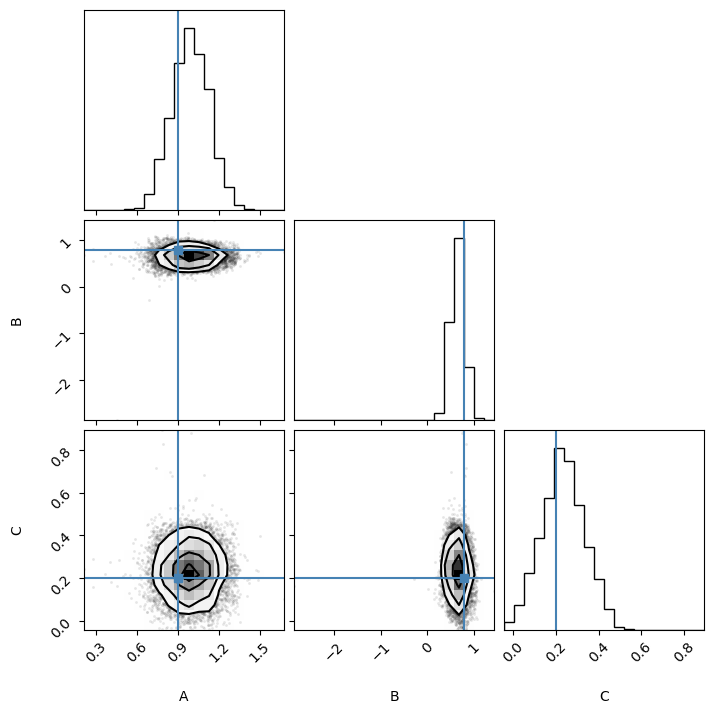

 40%|████      | 400/1000 [03:26<04:17,  2.33it/s, loss=51.03, T=1]

Epoch 400, loss 51.0257682800293


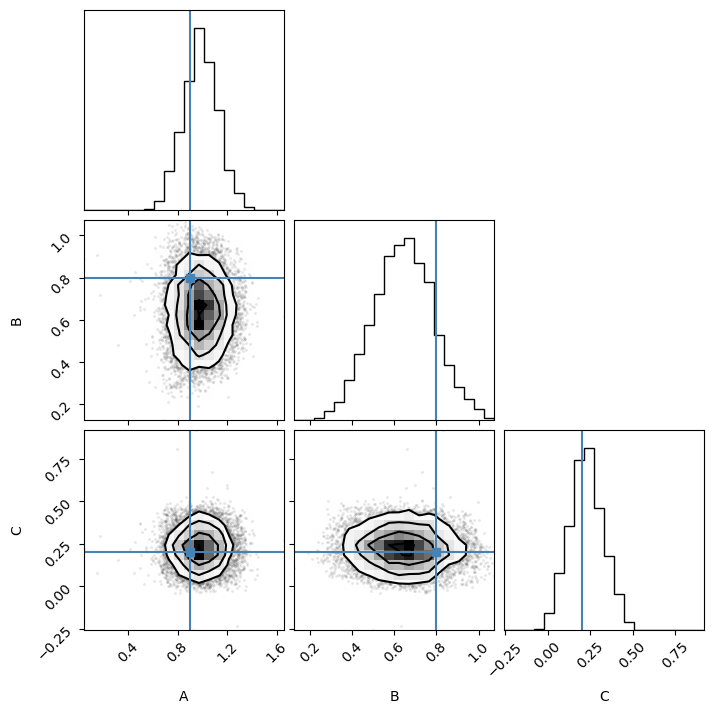

 45%|████▌     | 450/1000 [03:52<04:02,  2.27it/s, loss=51.06, T=1]

Epoch 450, loss 51.06284713745117


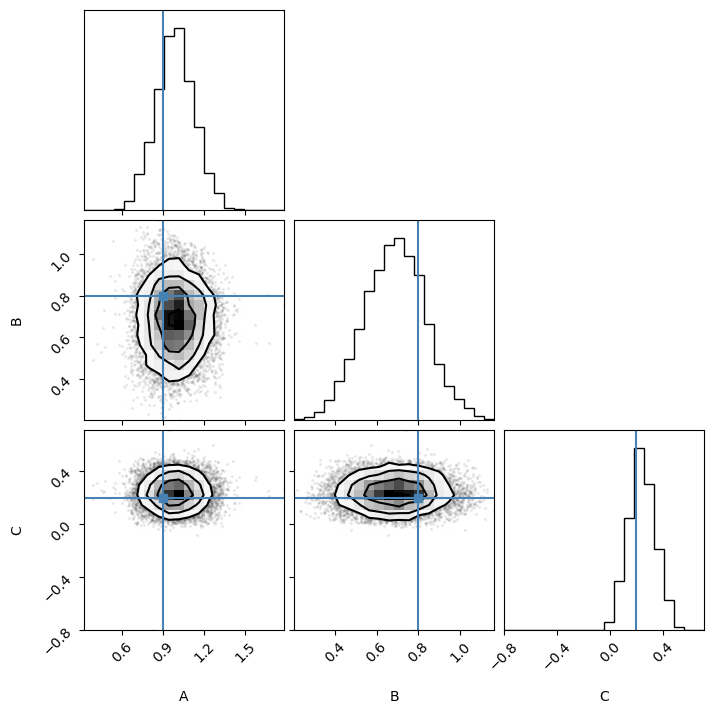

 46%|████▌     | 458/1000 [03:56<04:40,  1.93it/s, loss=51.04, T=1]


KeyboardInterrupt: 

In [43]:
if __name__ == '__main__':


    log_l = LogL()              

    # Test likelihood
    l = log_l(log_l.true_gw_params)
    print(f'log likelihood of true params = {l}')

    n_params = len(log_l.gw_params)
    flow_num_layers = 4
    hidden_size = 16
    mlp_num_layers = 2
    num_bins = 4


    # perform variational inference
    epochs = 1000
    loss = dict(train=[], val=[])
    Nsamps = 1000

    learning_rate = 0.01
    optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

    prng_seq = hk.PRNGSequence(42)
    key = next(prng_seq)
    params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
    opt_state = optimiser.init(params)

    from tqdm import tqdm, trange
   
    ldict = dict(loss = 0, T=1)

    with trange(epochs) as tepochs:
        for epoch in tepochs:
  
            #update NN params (stochastic gradient descent with Adam optimiser)
            prng_key = next(prng_seq)
            loss = loss_fn(params,  prng_key, Nsamps)
            ldict['loss'] = f'{loss:.2f}'
            tepochs.set_postfix(ldict, refresh=True)
            params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            
            
            #print results every 50 iterations
            if epoch%50 == 0:
                print(f'Epoch {epoch}, loss {loss}')
                x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
                x_gen = np.array(x_gen, copy=False)
                p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
                truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
                fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
                plt.show()

    print("Done!")

    x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

    x_gen = np.array(x_gen, copy=False)
    p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
    truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
    fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
    plt.show()
    plt.savefig(f'posterior_${epochs}.png')